In [1]:
%pylab qt
%matplotlib inline

import datetime
import astropy.constants as const
import sympy as sympy
import warnings
import pandas
from orbital_parameters import *

def epoch_to_julian(date):
    """converts epoch to julian day"""
    J2000 = 2451545.
    delta = (date - datetime.datetime(2000, 1, 1, 12))
    j     = delta.days + delta.seconds/24/3600
    return J2000 + j

def mysavefig(name):
    plt.tight_layout()
    plt.savefig(name, dpi=200)

Populating the interactive namespace from numpy and matplotlib


This website seems to provide heliocentric ecliptic coordinates of various objects: https://omniweb.gsfc.nasa.gov/coho/helios/heli.html.
However, time span is somehow limited.

# Prototyping: test example with Ceres

The calculation of comet ephemerides, Tatum J. 1982

- Tutoriel :

https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Book%3A_Celestial_Mechanics_(Tatum)/10%3A_Computation_of_an_Ephemeris/10.07%3A_Calculating_the_Position_of_a_Comet_or_Asteroid

https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Book%3A_Celestial_Mechanics_(Tatum)/09%3A_The_Two_Body_Problem_in_Two_Dimensions/9.05%3A_Position_in_an_Elliptic_Orbit

- Data :

https://theskylive.com/67p-info#elements

https://ssd.jpl.nasa.gov/sbdb.cgi?sstr=67P%2FChuryumov-Gerasimenko;orb=0;cov=0;log=0;cad=0#elem

- Heliocentric ecliptic coordinates

https://omniweb.gsfc.nasa.gov/coho/helios/coor_des.html

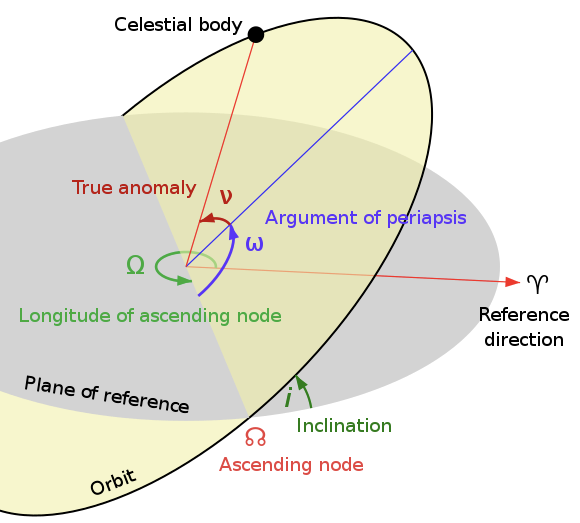

In [2]:
date  = datetime.datetime(2002, 7, 15) # given date at which we want to know the position

a     = 2.7664122 # semimajor axis of the ellipse in astronomical units
Omega = 80.48632  # longitude of ascending mode in degree
e     = 0.0791158 # eccentricity
omega = 73.98440  # argument of periapsis in degree
i     = 10.58347  # inclinaison in degree
M0    = 189.27500 # mean anomaly in degree at epoch
t0    = datetime.datetime(2002, 5, 6) # epoch

# Convert values in rad, au and julian days
Omega *= np.pi/180
omega *= np.pi/180
i     *= np.pi/180
M0    *= np.pi/180
t0     = epoch_to_julian(t0)

# other relevant quantities
P = (2*np.pi*np.sqrt((a*const.au)**3/const.G/const.M_sun)).value / 24/3600 # orbital period
n = 2*np.pi/P # average motion (average orbital angular speed) in rad per day

# compute mean anomaly in rad at a given date
def mean_anomaly(datetime, M0=M0, t0=t0):
    t = epoch_to_julian(datetime)
    return M0 + n*(t-t0)
M = mean_anomaly(date)

# compute excentric anomaly in rad at a given date
def excentric_anomaly(datetime, M0=M0, t0=t0, e=e):
    M = mean_anomaly(date, M0=M0, t0=t0)
    x = sympy.Symbol("x")
    E = sympy.solvers.nsolve(x - e*sympy.sin(x) - M, x, 1)
    return float(E)
E = excentric_anomaly(date)

# compute true anomaly in rad at a given date
def true_anomaly(datetime, M0=M0, t0=t0, e=e):
    E = excentric_anomaly(date)
    cos_nu = (np.cos(E) - e) / (1 - e*np.cos(E))
    sin_nu = (np.sqrt(1-e**2)*np.sin(E)) / (1 - e*np.cos(E))
    tan_nu = (np.sqrt(1-e**2)*np.sin(E)) / (np.cos(E)-e)
    tan_demi_nu = np.sqrt((1+e)/(1-e))*np.tan(E/2)
    nu = 2*np.arctan(tan_demi_nu)
    # checking
    ref_str = "%10.3f %10.3f %10.3f %10.3f"%(cos_nu, sin_nu, tan_nu, tan_demi_nu)
    num_str = "%10.3f %10.3f %10.3f %10.3f"%(np.cos(nu), np.sin(nu), np.tan(nu), np.tan(nu/2))
    if not (ref_str==num_str):
        warnings.warn("true_anomaly value not reliable")
    return nu
nu = true_anomaly(date)

# compute heliocentric distance in au
def heliocentric_distance(datetime, M0=M0, t0=t0, e=e, a=a):
    nu = true_anomaly(datetime, M0=M0, t0=t0, e=e)
    r = a*(1-e**2) / (1+e*np.cos(nu))
    return r
r = heliocentric_distance(date)

# from here we neglect the inclinaison i of the orbit

# heliocentric ecliptic coordinates in au
def heliocentric_ecliptic_coordinates(datetime, M0=M0, t0=t0, e=e, a=a, Omega=Omega, omega=omega, i=i):
    nu    = true_anomaly(datetime, M0=M0, t0=t0, e=e)
    theta = omega + nu # argument of latitude
    r = heliocentric_distance(datetime, M0=M0, t0=t0, e=e, a=a)
    X = r * (np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta)*np.cos(i))
    Y = r * (np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta)*np.cos(i))
    Z = r * np.sin(theta)*np.sin(i)
    return X, Y, Z

heliocentric_ecliptic_coordinates(date)

/Users/remimetzdorff/opt/anaconda3/lib/python3.8/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.solvers.solvers with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.solvers.solvers instead.
See https://github.com/sympy/sympy/issues/18245 for more info.

  self.Warn(


(2.909066062971024, -0.23364624345321552, -0.5432880106370175)

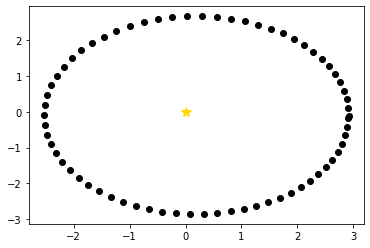

In [3]:
start = datetime.datetime(2002, 7, 1)
stop  = datetime.datetime(2007, 2, 1)
step_day = 25

X,Y,Z = [],[],[]
date = start
while date<stop:
    date += datetime.timedelta(days=step_day)
    x,y,z = heliocentric_ecliptic_coordinates(date)
    X.append(x)
    Y.append(y)
    Z.append(z)
plt.plot([0],[0], "*", color="gold", markersize=10)
plt.plot(X,Y, "ok")

# Make it a function

In [2]:
# calculate heliocentric ecliptic coordinates in au
def heliocentric_ecliptic_coordinates(datetime, a, e, Omega, omega, i, M0, t0):
    """
    PARAMETERS
        datetime: date at which we want to know the position of the comet
        a       : semimajor axis of the ellipse in astronomical units
        e       : eccentricity
        Omega   : longitude of ascending mode in degree
        omega   : argument of periapsis in degree
        i       : inclinaison in degree
        M0      : mean anomaly in degree at epoch
        t0      : reference epoch
    RETURNS
        X,Y and Z heliocentric ecliptic coordinates in au
    """
    
    # Convert values in rad, au and julian days
    Omega *= np.pi/180
    omega *= np.pi/180
    i     *= np.pi/180
    M0    *= np.pi/180
    t0     = epoch_to_julian(t0)
    
    # other relevant quantities
    P = (2*np.pi*np.sqrt((a*const.au)**3/const.G/const.M_sun)).value / 24/3600 # orbital period in days
    n = 2*np.pi/P # average motion (average orbital angular speed) in rad per day

    # compute mean anomaly in rad at a given date
    t = epoch_to_julian(datetime)
    M = M0 + n*(t-t0)

    # compute excentric anomaly in rad at a given date
    x = sympy.Symbol("x")
    E = sympy.solvers.nsolve(x - e*sympy.sin(x) - M, x, 1)
    E = float(E)

    # compute true anomaly in rad at a given date
    cos_nu = (np.cos(E) - e) / (1 - e*np.cos(E))
    sin_nu = (np.sqrt(1-e**2)*np.sin(E)) / (1 - e*np.cos(E))
    tan_nu = (np.sqrt(1-e**2)*np.sin(E)) / (np.cos(E)-e)
    tan_demi_nu = np.sqrt((1+e)/(1-e))*np.tan(E/2)
    nu = 2*np.arctan(tan_demi_nu)
    # checking
    ref_str = "%10.3f %10.3f %10.3f %10.3f"%(cos_nu, sin_nu, tan_nu, tan_demi_nu)
    num_str = "%10.3f %10.3f %10.3f %10.3f"%(np.cos(nu), np.sin(nu), np.tan(nu), np.tan(nu/2))
    if not (ref_str==num_str):
        warnings.warn("true_anomaly value not reliable")

    # compute heliocentric distance in au
    r = a*(1-e**2) / (1+e*cos_nu)
    
    # final calculation (might be good to write cos(theta) with cos_nu and sin_nu values)
    theta = omega + nu # argument of latitude
    X = r * (np.cos(Omega)*np.cos(theta) - np.sin(Omega)*np.sin(theta)*np.cos(i))
    Y = r * (np.sin(Omega)*np.cos(theta) + np.cos(Omega)*np.sin(theta)*np.cos(i))
    Z = r * np.sin(theta)*np.sin(i)
    return X, Y, Z

def calculate_orbit(body, start, stop, step):
    X,Y,Z = [],[],[]
    date = start
    while date<stop:
        x,y,z = heliocentric_ecliptic_coordinates(date,
                                                  a=body["a"],
                                                  e=body["e"],
                                                  Omega=body["Omega"],
                                                  omega=body["omega"],
                                                  i=body["i"],
                                                  M0=body["M0"],
                                                  t0=body["t0"])
        date += datetime.timedelta(days=step)
        X.append(x)
        Y.append(y)
        Z.append(z)
    return X,Y,Z

def plot_orbit(body, start, stop, step, ax, style=None, color=None):
    X,Y,Z = calculate_orbit(body, start, stop, step)
    if style is None:
        style = "o"
    if color is not None:
        ax.plot(X,Y, style, color=color)
    else:
        ax.plot(X,Y, style)
    return X,Y,Z

In [5]:
# TEST
# Should give the same results as before

# Orbital parameter
a     = 2.7664122 # semimajor axis of the ellipse in astronomical units
Omega = 80.48632  # longitude of ascending node in degree
e     = 0.0791158 # eccentricity
omega = 73.98440  # argument of periapsis in degree
i     = 10.58347  # inclinaison in degree
M0    = 189.27500 # mean anomaly in degree at epoch
t0    = datetime.datetime(2002, 5, 6) # reference epoch

# Date
date  = datetime.datetime(2002, 7, 15) # given date at which we want to know the position

heliocentric_ecliptic_coordinates(date, a, e, Omega, omega, i, M0, t0)

(2.909066062971024, -0.23364624345321552, -0.5432880106370175)

# Tests on new objects

For planets, the mean longitude $L = M+\Omega+\omega$ is used to characterize the orbit.

Following plots have been checked using this solar system simulation https://theskylive.com/3dsolarsystem?objs=c2020m3|88p|156p|67p&date=2021-11-13&h=23&m=40&

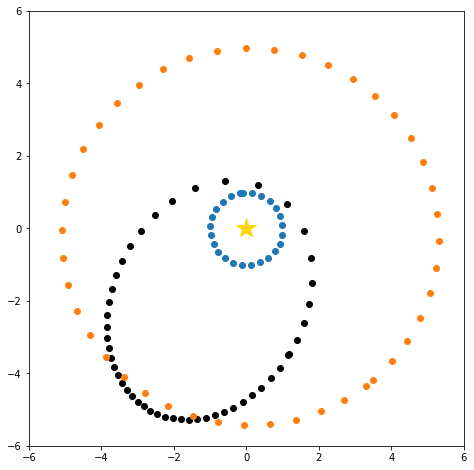

In [7]:
start = datetime.datetime(2002, 7, 1)
stop  = datetime.datetime(2009, 2, 1)
step_day = 50

plt.figure(figsize=(12,8))
sps = (1,1)
ax = plt.subplot2grid(sps, (0,0))
ax.set_aspect("equal")
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.plot([0],[0], "*", color="gold", markersize=20)

_ = plot_orbit(planet_earth, datetime.datetime(2021, 1, 1), datetime.datetime(2021, 12, 31), 15, ax, color="C0")
_ = plot_orbit(comet_tchouri, datetime.datetime(2021, 1, 1), datetime.datetime(2027, 6, 20), 50, ax, color="k")
_ = plot_orbit(planet_jupiter, datetime.datetime(2021, 1, 1), datetime.datetime(2032, 11, 1), 100, ax, color="C1")

# Create data files

## Full data

In [8]:
start = datetime.datetime(2021, 1, 1)
stop  = datetime.datetime(2036, 1, 1)
step  = 1

for body in [planet_earth, planet_jupiter, comet_tchouri]:
    X,Y,Z = calculate_orbit(body, start, stop, step)
    data = pandas.Series(Y, index=X)
    filename = body["name"]+".txt"
    data.to_csv(filename, sep="\t", header=False)
    header_earth = [u"# fichier "+filename+"\n",
                    u"##############################################################################\n",
                    u"# Position prevue de la "+body["category_fr"]+" "+body["name_fr"]+" par rapport au Soleil.\n",
                    u"# Les donnees sont toutes prises a un jour d'intervalle.\n",
                    u"# La premiere ligne correspond au 1er janvier 2021.\n"
                    u"# Les distances sont exprimees en unite astronomique (au) : 1 au = %9.3e m\n"%(const.au.value),
                    u"##############################################################################\n"
                    u"X (abscisse)\tY (ordonnee)\n"
                    ]
    with open(filename, "r") as f:
        file_header = header_earth+f.readlines()
    with open(filename, "w") as f:
        f.writelines(file_header)

## Simplified data

In [17]:
for i, body in enumerate([planet_earth]):#, planet_jupiter, comet_tchouri]):
    P = body["P"]
    n_pts = 25
    step_day = max(1,int(P/n_pts))
    start = datetime.datetime(2021, 1, 1)
    stop  = start+datetime.timedelta(days=P)
    X,Y,Z = calculate_orbit(body, start, stop, step_day)
    data = pandas.Series(Y, index=X)
    filename = body["name"]+".txt"
    data.to_csv(filename, sep="\t", header=False)
    header_earth = [u"# fichier "+filename+"\n",
                    u"##############################################################################\n",
                    u"# Position prevue de la "+body["category_fr"]+" "+body["name_fr"]+" par rapport au Soleil.\n",
                    u"# Les donnees sont toutes prises a %.0f jours d'intervalle.\n"%(step_day),
                    u"# La premiere ligne correspond au 1er janvier 2021.\n"
                    u"# Les distances sont exprimees en unite astronomique (au) : 1 au = %9.3e m\n"%(const.au.value),
                    u"##############################################################################\n"
                    u"X (abscisse)\tY (ordonnee)\n"
                    ]
    with open(filename, "r") as f:
        file_header = header_earth+f.readlines()
    with open(filename, "w") as f:
        f.writelines(file_header)

# Pupil program tests

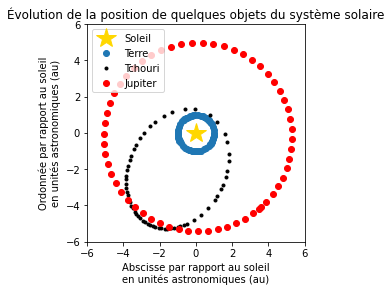

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Lecture des fichiers de données pour récupérer les positions des planètes
# Terre
data_terre = np.loadtxt("earth.txt", skiprows=8)
x_terre, y_terre = data_terre[:,0], data_terre[:,1]
# Tchouri
data_tchouri = np.loadtxt("tchouri.txt", skiprows=8)
x_tchouri, y_tchouri = data_tchouri[:,0], data_tchouri[:,1]
# Jupiter
data_jupiter = np.loadtxt("jupiter.txt", skiprows=8)
x_jupiter, y_jupiter = data_jupiter[:,0], data_jupiter[:,1]

#######################
# PARAMETRES DE L'ETUDE
#######################
# Pendant combien de jours veut-on représenter la position des planètes ?
nb_jours = 365 #200
nb_jours = 2350
nb_jours = 365*12


# Combien de jours entre deux positions successives ?
delta_jours = 10#75
delta_jours = 75#75

###########################
# MISE A JOUR DES POSITIONS
###########################
X_terre = [x_terre[i] for i in range(len(x_terre[:nb_jours])) if i%delta_jours==0]
Y_terre = [y_terre[i] for i in range(len(y_terre[:nb_jours])) if i%delta_jours==0]
X_tchouri = [x_tchouri[i] for i in range(len(x_tchouri[:nb_jours])) if i%delta_jours==0]
Y_tchouri = [y_tchouri[i] for i in range(len(y_tchouri[:nb_jours])) if i%delta_jours==0]
X_jupiter = [x_jupiter[i] for i in range(len(x_jupiter[:nb_jours])) if i%delta_jours==0]
Y_jupiter = [y_jupiter[i] for i in range(len(y_jupiter[:nb_jours])) if i%delta_jours==0]

########################################
# REPRESENTATION GRAPHIQUE DES POSITIONS
########################################
plt.figure()
ax = plt.subplot2grid((1,1), (0,0))
ax.set_aspect("equal")
# Le Soleil
plt.plot([0],[0], "*", color="gold", markersize=20, label="Soleil")

# La Terre
plt.plot(X_terre, Y_terre, "oC0", label="Terre")

# Tchouri
plt.plot(X_tchouri, Y_tchouri, ".k", label="Tchouri")

# Tchouri
plt.plot(X_jupiter, Y_jupiter, "or", label="Jupiter")

# Changements d'échelle pour les axes (limites du graphe)
plt.xlim(-6,6) #(-2,2)
plt.ylim(-6,6) #(-2,2)

# Nom des axes
plt.title("Évolution de la position de quelques objets du système solaire")
plt.xlabel("Abscisse par rapport au soleil\nen unités astronomiques (au)")
plt.ylabel("Ordonnée par rapport au soleil\nen unités astronomiques (au)")
plt.legend(loc = "upper left")
plt.show()

# Show off

In [4]:
# https://theskylive.com/3dsolarsystem
%matplotlib qt

def plot_orbit(body, start, stop, step, ax, style=None, color=None):
    X,Y,Z = calculate_orbit(body, start, stop, step)
    if style is None:
        style = "-"
    if body["category"] == "planet":
        linewidth=0.5
        alpha=1
    else:
        linewidth=0.2
        alpha=0.5
    ax.plot(X,Y, style, color=color, linewidth=linewidth, alpha=alpha)
    return X,Y,Z

a_max = 40
quickplot = False

plt.figure(figsize=(12,8))
sps = (1,1)
ax = plt.subplot2grid(sps, (0,0))
ax.set_aspect("equal")
ax.set_xlim(-a_max,a_max)
ax.set_ylim(-a_max,a_max)
ax.plot([0],[0], "*", color="gold", markersize=20)

for i, body in enumerate(planets+comets+asteroids+dwarf_planets):
    P = body["P"]
    if quickplot:
        n_pts = 50
    else:
        n_pts = 100
        if body["name"] in ["halley", "swift-tutle"]:
            n_pts = 10000
        elif body["name"] in ["tchouri", "borrelly"]:
            n_pts = 1000
    step_day = max(1,int(P/n_pts))
    start = datetime.datetime(2021, 11, 1)
    stop  = start+datetime.timedelta(days=P)
    X,Y,Z = plot_orbit(body, start, stop, step_day, ax, style="-", color="C"+str(i))
    # Potition at epoch
    if body["category"] == "planet":
        marker = "o"
        alpha=1
        fontsize="small"
    else:
        marker = "."
        alpha=0.5
        fontsize="x-small"
    x0, y0 = X[0], Y[0]
    plt.plot([x0], [y0], marker, color="C"+str(i), label=body["name"])
    plt.annotate(body["name"], (x0,y0), color="C"+str(i), textcoords="offset points", xytext=(2,2),
                 fontsize=fontsize, horizontalalignment='left', verticalalignment='bottom', alpha=alpha)

plt.title("Solar system at date "+str(start))
plt.xlabel("X (au)")
plt.ylabel("Y (au)")

mysavefig("solar_system.png")